In [1]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 1.7 MB/s eta 0:00:00


In [2]:
import praw
import pandas as pd
print("done!")

done!


In [3]:
%cd sample_data

/content/sample_data


In [4]:
data=pd.read_csv('chatgpt-reddit-comments.csv')

In [5]:
data.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         52413 non-null  object
 1   comment_id         52415 non-null  object
 2   comment_parent_id  52415 non-null  object
 3   comment_body       52415 non-null  object
 4   subreddit          52415 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [7]:
data.describe()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
count,52413,52415,52415,52415,52415
unique,29712,52413,22596,51042,5
top,0,comment_id,t3_107vs7i,[deleted],r/ChatGPT
freq,4,3,239,661,29711


In [8]:
data.columns

Index(['Unnamed: 0', 'comment_id', 'comment_parent_id', 'comment_body',
       'subreddit'],
      dtype='object')

In [9]:
data["comment_body"] = data["comment_body"].fillna("")

In [10]:
import re

In [11]:
chatgpt_regex = r"\bchatgpt\b"

In [12]:
chatgpt_comments = data[data["comment_body"].str.contains(chatgpt_regex)]

In [13]:
import pandas as pd
from textblob import TextBlob


In [14]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
def textblob_sentiment(comment):
  sentiment = TextBlob(comment).sentiment
  polarity = sentiment.polarity
  subjectivity = sentiment.subjectivity
  return polarity, subjectivity

In [17]:
def vader_sentiment(comment):
  vader = SentimentIntensityAnalyzer()
  scores = vader.polarity_scores(comment)
  compound_score = scores["compound"]
  return compound_score

In [18]:
chatgpt_comments["textblob_polarity"], chatgpt_comments["textblob_subjectivity"] = zip(*chatgpt_comments["comment_body"].apply(textblob_sentiment))
chatgpt_comments["vader_compound"] = chatgpt_comments["comment_body"].apply(vader_sentiment)

<ipython-input-18-57f056fd497c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_comments["textblob_polarity"], chatgpt_comments["textblob_subjectivity"] = zip(*chatgpt_comments["comment_body"].apply(textblob_sentiment))
<ipython-input-18-57f056fd497c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_comments["textblob_polarity"], chatgpt_comments["textblob_subjectivity"] = zip(*chatgpt_comments["comment_body"].apply(textblob_sentiment))
<ipython-input-18-57f056fd497c>:2: SettingWithCopyWarn

In [19]:
sentiment_results = chatgpt_comments["comment_body"].apply(textblob_sentiment)
sentiment_df = pd.DataFrame(sentiment_results.tolist(), columns=["textblob_polarity", "textblob_subjectivity"])
chatgpt_comments = chatgpt_comments.assign(**sentiment_df)

In [20]:
vader_scores = chatgpt_comments["comment_body"].apply(vader_sentiment)
chatgpt_comments = chatgpt_comments.assign(vader_compound=vader_scores)


In [21]:
print(chatgpt_comments[["comment_body", "textblob_polarity", "textblob_subjectivity", "vader_compound"]].head())

                                          comment_body  textblob_polarity  \
2    chatgpt karma whoring is here folks! just when...            0.12500   
125         This sounds like it was written by chatgpt            0.00000   
131  >chatgpt karma whoring is here folks! just whe...            0.10873   
173           So davinci-003 and chatgpt is different?            0.00000   
370  I've explored this quite a bit, because I'm pr...           -0.12500   

     textblob_subjectivity  vader_compound  
2                 0.454592         -0.2001  
125               0.355556          0.3612  
131               0.733730          0.2993  
173               0.000000          0.0000  
370               0.491667          0.4019  


In [22]:
!python -m nltk.downloader stopwords
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
STOPWORDS = stopwords.words("english")


def clean_text_nltk(text):
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    filtered_tokens = " ".join(word for word in text.split() if word not in STOPWORDS)
    return filtered_tokens

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
data.loc[:, "comment_body"] = data.comment_body.apply(clean_text_nltk)
data.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,shocked days need clickbait,r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,angry right wasted time reading post sub click...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring folks think stream thoug...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,worked ngl,r/ChatGPT
4,4,izu2as9,t3_zj2aeu,certified 10 10 must see moment really shock core,r/ChatGPT


In [24]:
data.iloc[0]["comment_body"]

'shocked days need clickbait'

In [25]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(data.iloc[0]["comment_body"])["compound"]

-0.3182

In [27]:
def sentiment_score(text):
    score = sia.polarity_scores(text)["compound"]
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0


data["category"] = data.comment_body.apply(sentiment_score)
data.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,category
0,0,iztdxuh,t3_zj2aeu,shocked days need clickbait,r/ChatGPT,-1
1,1,iztn0q0,t3_zj2aeu,angry right wasted time reading post sub click...,r/ChatGPT,-1
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,-1
3,3,iztfhtb,t3_zj2aeu,worked ngl,r/ChatGPT,0
4,4,izu2as9,t3_zj2aeu,certified 10 10 must see moment really shock core,r/ChatGPT,-1


In [28]:
data.category.value_counts()

category
 1    27819
 0    12845
-1    11752
Name: count, dtype: int64

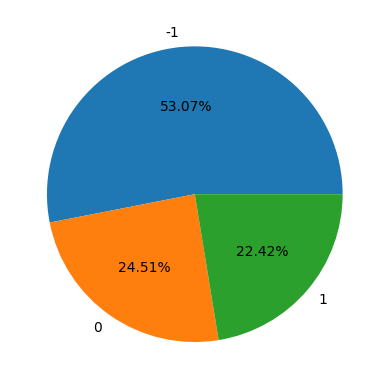

In [29]:
import matplotlib.pyplot as plt
plt.pie(data.category.value_counts(), labels=data.category.unique(), autopct="%.2f%%");

-1 --> negative
   0 --> neutral
1 --> positive

In [30]:
import os
import re
import shutil


import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import spacy
from imblearn import under_sampling
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

In [31]:
data.rename(columns={data.columns[0]: 'SNo'}, inplace=True)

In [32]:
data.head()

,SNo,comment_id,comment_parent_id,comment_body,subreddit,category
0,0,iztdxuh,t3_zj2aeu,shocked days need clickbait,r/ChatGPT,-1
1,1,iztn0q0,t3_zj2aeu,angry right wasted time reading post sub click...,r/ChatGPT,-1
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring folks think stream thoug...,r/ChatGPT,-1
3,3,iztfhtb,t3_zj2aeu,worked ngl,r/ChatGPT,0
4,4,izu2as9,t3_zj2aeu,certified 10 10 must see moment really shock core,r/ChatGPT,-1


In [33]:
data = data.drop(columns=['SNo'])

In [34]:
print(data.head())

  comment_id comment_parent_id  \
0    iztdxuh         t3_zj2aeu   
1    iztn0q0         t3_zj2aeu   
2    izudrph         t3_zj2aeu   
3    iztfhtb         t3_zj2aeu   
4    izu2as9         t3_zj2aeu   

                                        comment_body  subreddit  category  
0                        shocked days need clickbait  r/ChatGPT        -1  
1  angry right wasted time reading post sub click...  r/ChatGPT        -1  
2  chatgpt karma whoring folks think stream thoug...  r/ChatGPT        -1  
3                                         worked ngl  r/ChatGPT         0  
4  certified 10 10 must see moment really shock core  r/ChatGPT        -1  


In [35]:
!python3 -m nltk.downloader wordnet
!unzip /root/nltk_data/corpora/wordnet.zip -d nltk.data.path[4]


nltk_stem = nltk.PorterStemmer()
nltk_lemmat = nltk.WordNetLemmatizer()


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...
Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: nltk.data.path[4]/wordnet/
  inflating: nltk.data.path[4]/wordnet/lexnames  
  inflating: nltk.data.path[4]/wordnet/data.verb  
  inflating: nltk.data.path[4]/wordnet/index.adv  
  inflating: nltk.data.path[4]/wordnet/adv.exc  
  inflating: nltk.data.path[4]/wordnet/index.verb  
  inflating: nltk.data.path[4]/wordnet/cntlist.rev  
  inflating: nltk.data.path[4]/wordnet/data.adj  
  inflating: nltk.data.path[4]/wordnet/index.adj  
  inflating: nltk.data.path[4]/wordnet/LICENSE  
  inflating: nltk.data.path[4]/wordnet/citation.bib  
  inflating: nltk.data.path[4]/wordnet/noun.exc  
  inflating: nltk.data.path[4]/wordnet/verb.exc  
  inf

In [36]:
print(nltk_stem.stem("geese"))
print(nltk_stem.stem("goose"))

gees
goos


In [37]:
print(nltk_lemmat.lemmatize("geese"))
print(nltk_lemmat.lemmatize("goose"))

goose
goose


In [38]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("geese")
for token in doc:
    print(token.lemma_)

doc = nlp("goose")
for token in doc:
    print(token.lemma_)

geese
goose


In [39]:
def lemmat_corpus(doc):
    filtered_doc = "".join(nltk_lemmat.lemmatize(word) for word in doc)
    return filtered_doc
data.loc[:, "comment_body"] = data.comment_body.apply(lemmat_corpus)
data.comment_body

0                              shocked days need clickbait
1        angry right wasted time reading post sub click...
2        chatgpt karma whoring folks think stream thoug...
3                                               worked ngl
4        certified 10 10 must see moment really shock core
                               ...                        
52411                                     read thank later
52412                       missing https openai com terms
52413                                    chatgtp think tos
52414    know referring tos sections seem noteworthy 2 ...
52415                                                     
Name: comment_body, Length: 52416, dtype: object

In [40]:
map = {1: "Positive", 0: "Neutral", -1: "Negative"}


def printWordCloud(x, cat):
    cat_tweet = " ".join([word for word in x[x["category"] == cat]["comment_body"]])

    wc = WordCloud(background_color="white", max_words=50, stopwords=STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(16, 10))
    plt.imshow(wc.generate(cat_tweet))
    plt.title("{} Sentiment Words".format(map[cat]), fontsize=20)
    plt.axis("off")
    plt.show()

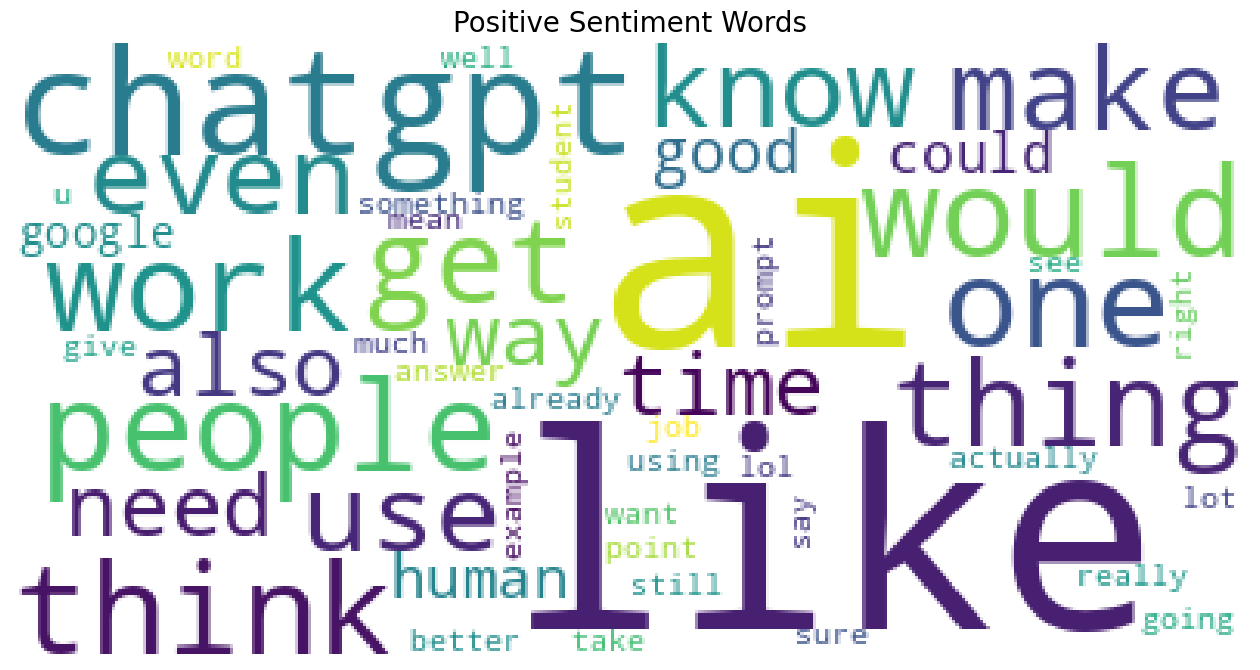

In [41]:
printWordCloud(data, 1)

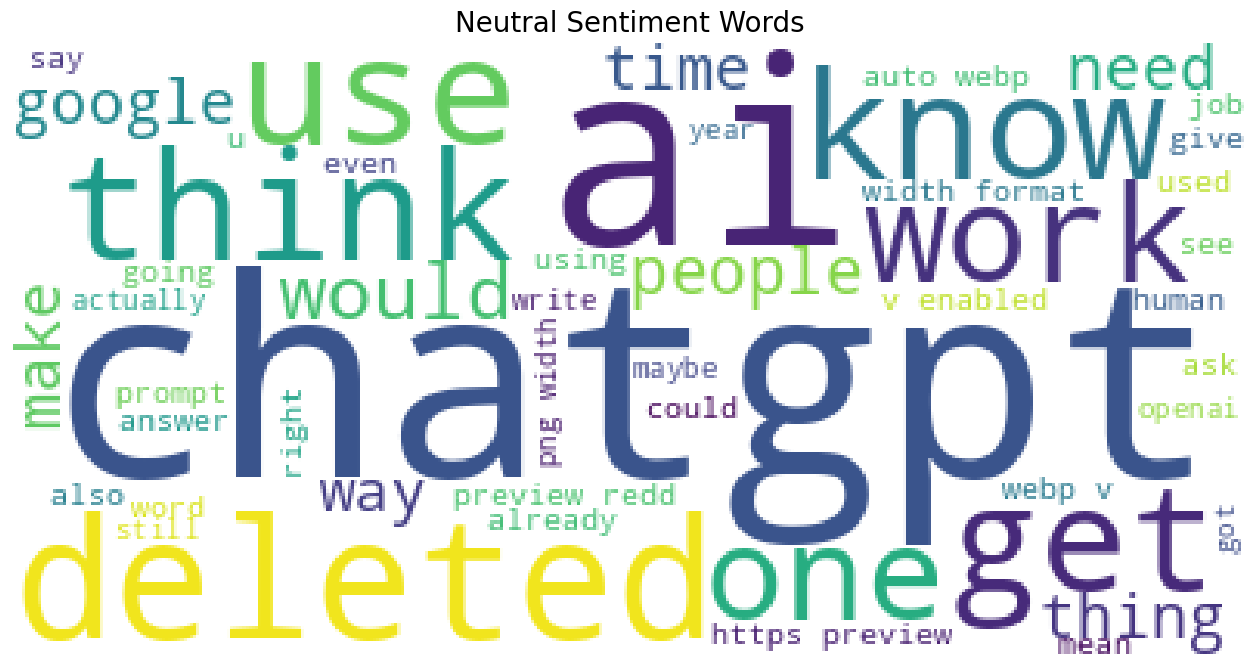

In [42]:
printWordCloud(data, 0)

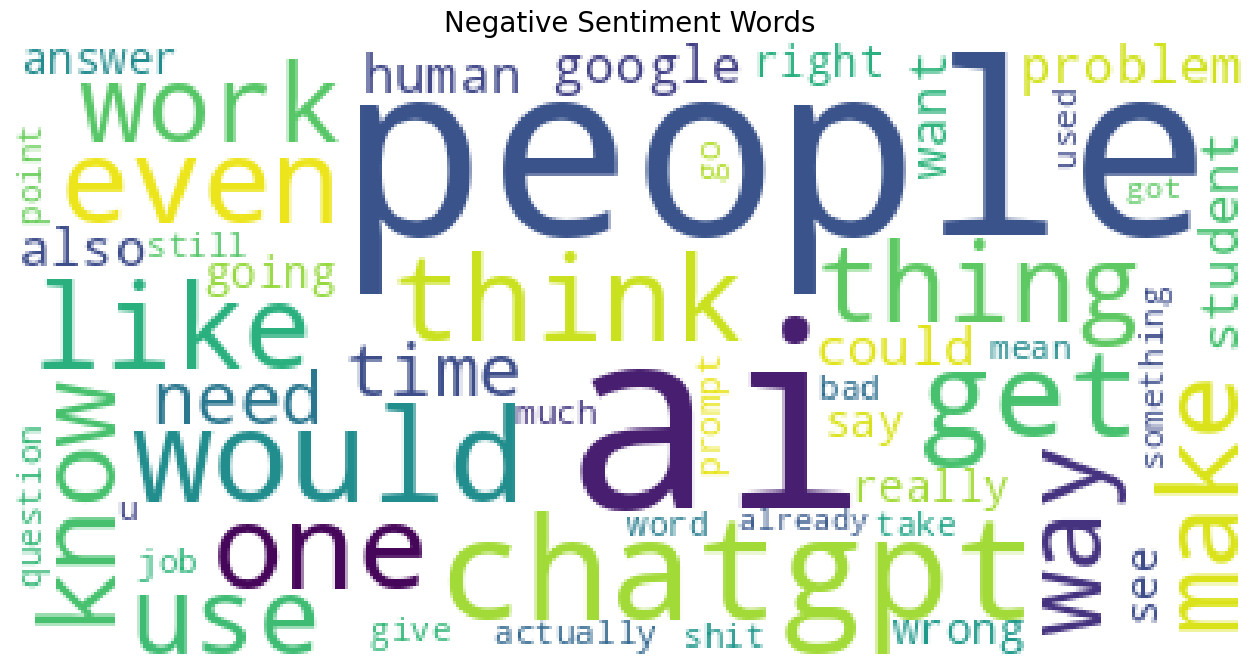

In [43]:
printWordCloud(data, -1)

In [44]:
undersample = under_sampling.RandomUnderSampler()

X, y = undersample.fit_resample(data.iloc[:10000, :-1], data.iloc[:10000, -1])

In [45]:
X = pd.DataFrame(X)
X.head()

,comment_id,comment_parent_id,comment_body,subreddit
0,iztdxuh,t3_zj2aeu,shocked days need clickbait,r/ChatGPT
1,iztn0q0,t3_zj2aeu,angry right wasted time reading post sub click...,r/ChatGPT
2,izudrph,t3_zj2aeu,chatgpt karma whoring folks think stream thoug...,r/ChatGPT
3,izu2as9,t3_zj2aeu,certified 10 10 must see moment really shock core,r/ChatGPT
4,izuo2mo,t3_zj2aeu,shit worked,r/ChatGPT


In [46]:
y.value_counts()

category
-1    2132
 0    2132
 1    2132
Name: count, dtype: int64

# **TfidfVectorizer**

In [47]:
X_ = "\n".join(X["comment_body"]).split("\n")

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(X_)
tranformed_X = tfidf_matrix.toarray()
tranformed_X.shape

(6396, 13636)

In [48]:
y.shape

(6396,)

Splitting into Training and Testing Data

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    tranformed_X, y, random_state=24, test_size=0.2, stratify=y
)

## **ML Models**

Naive Bayes

In [50]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

print(
    "Classification Report is:\n",
    classification_report(y_test, y_pred, zero_division=False),
)
print("Training Score:\n", gnb.score(x_train, y_train) * 100)
print("Testing Score:\n", gnb.score(x_test, y_test) * 100)

Classification Report is:
               precision    recall  f1-score   support

          -1       0.52      0.63      0.57       426
           0       0.80      0.63      0.70       427
           1       0.53      0.53      0.53       427

    accuracy                           0.60      1280
   macro avg       0.62      0.60      0.60      1280
weighted avg       0.62      0.60      0.60      1280

Training Score:
 96.63799843627834
Testing Score:
 59.765625


Random Forest

In [51]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print(
    "Classification Report is:\n",
    classification_report(y_test, y_pred, zero_division=False),
)
print("Training Score:\n", rfc.score(x_train, y_train) * 100)
print("Testing Score:\n", rfc.score(x_test, y_test) * 100)

Classification Report is:
               precision    recall  f1-score   support

          -1       0.78      0.54      0.64       426
           0       0.70      0.92      0.79       427
           1       0.76      0.74      0.75       427

    accuracy                           0.73      1280
   macro avg       0.74      0.73      0.73      1280
weighted avg       0.74      0.73      0.73      1280

Training Score:
 100.0
Testing Score:
 73.4375


## **DL Models**

In [52]:
!pip install Keras

import numpy as np


from keras.models import Model,Sequential

from keras.layers import Dense, Input, Dropout, LSTM, Activation

from keras.layers import Embedding

from keras.preprocessing import sequence,text

from matplotlib import pyplot

 target label "category" is not having binary values. So instead we use multi-class classification. Also,everytime we run the cell, we were obtaining a different accuracy due to random initialization. Hence, we set random seeds for reproducibility

LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          640000    
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 100, 128)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 100, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

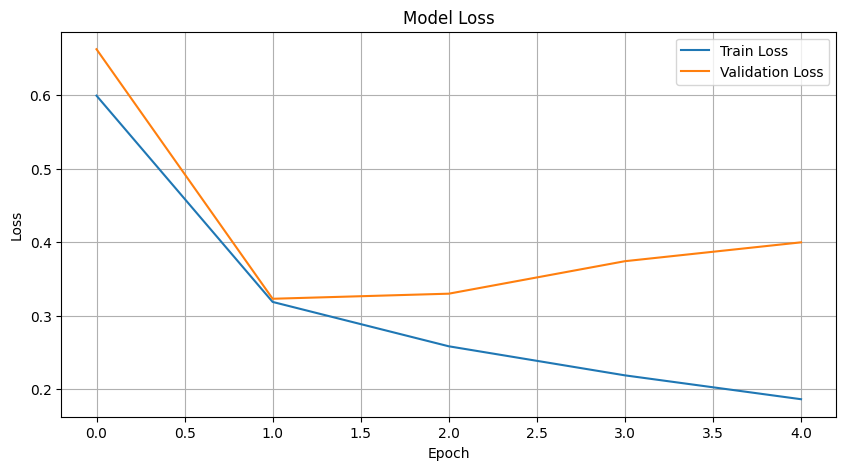

In [61]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Convert -1, 0, 1 to 0, 1, 2 respectively for multi-class classification
y_train_encoded = y_train + 1
y_test_encoded = y_test + 1

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with shuffling disabled for consistency
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint], shuffle=False)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


CNN

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 batch_normalization_2 (Bat  (None, 24, 128)           512       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 20, 64)           

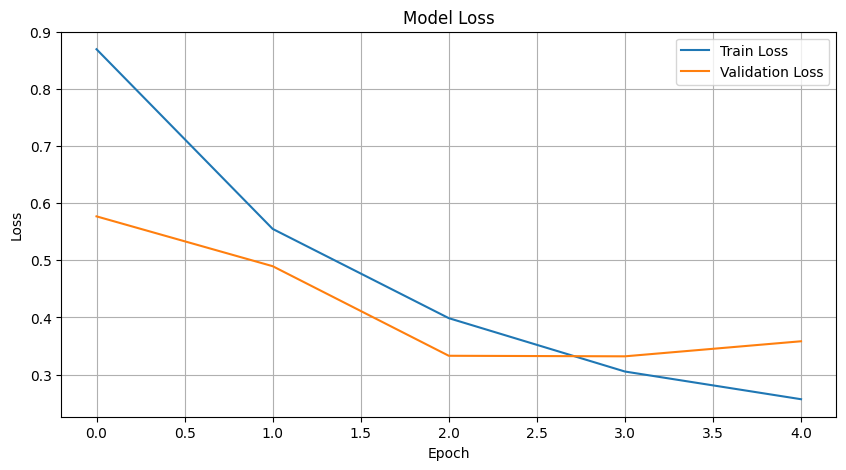

In [60]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import he_uniform

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Convert -1, 0, 1 to 0, 1, 2 respectively for multi-class classification
y_train_encoded = y_train + 1
y_test_encoded = y_test + 1

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu', kernel_initializer=he_uniform()))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(64, 5, activation='relu', kernel_initializer=he_uniform()))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())  # Flatten the output of the convolutional layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with shuffling disabled for consistency
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint], shuffle=False)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 24, 128)           512       
 Normalization)                                                  
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 64)           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1049/1049 [==============================] - 97s 92ms/step - loss: 0.3838 - accuracy: 0.8701 - val_loss: 0.3511 - val_accuracy: 0.8834
Epoch 3/5
1049/1049 [==============================] - 94s 89ms/step - loss: 0.2961 - accuracy: 0.9059 - val_loss: 0.3527 - val_accuracy: 0.8877
Epoch 4/5
1049/1049 [==============================] - 102s 97ms/step - loss: 0.2535 - accuracy: 0.9234 - val_loss: 0.3530 - val_accuracy: 0.8877
Epoch 5/5
328/328 [==============================] - 7s 22ms/step - loss: 0.3429 - accuracy: 0.8887
Test Accuracy: 0.89


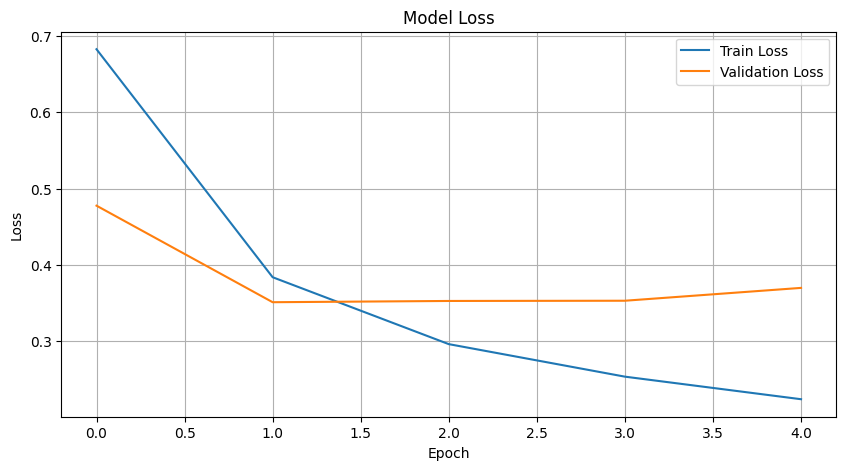

In [59]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import he_uniform

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Convert -1, 0, 1 to 0, 1, 2 respectively for multi-class classification
y_train_encoded = y_train + 1
y_test_encoded = y_test + 1

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu', kernel_initializer=he_uniform()))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(64, 5, activation='relu', kernel_initializer=he_uniform()))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with shuffling disabled for consistency
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint], shuffle=False)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
